In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats import kurtosis, skew
import gc
import json
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from pathlib import Path
import sys
import re

from scripts import feature_engineering

In [3]:
path=Path('/kaggle/data_science_bowl')
path

PosixPath('/kaggle/data_science_bowl')

In [4]:
def read_data():
    train_df = pd.read_csv(path/'train.csv')
    test_df = pd.read_csv(path/'test.csv')
    train_labels_df = pd.read_csv(path/'train_labels.csv')
    specs_df = pd.read_csv(path/'specs.csv')
    return train_df, test_df, train_labels_df, specs_df

In [5]:
%%time
train_df, test_df, train_labels_df, specs_df = read_data()

CPU times: user 31.9 s, sys: 2.05 s, total: 33.9 s
Wall time: 31.9 s


## Feature Engineering

### Cleanup

In [6]:
train_df = feature_engineering.remove_wrong_event_codes(train_df)
test_df = feature_engineering.remove_wrong_event_codes(test_df)

In [7]:
train_df = feature_engineering.remove_ids_with_no_assessment(train_df)

In [8]:
list_of_user_activities, activities_labels, activities_map, win_code, assess_titles, list_of_event_code, \
list_of_event_id, list_of_worlds, list_of_title, list_of_event_code_world, list_of_event_code_title, list_of_event_id_world = \
feature_engineering.create_structs(train_df, test_df)

In [9]:
train_samples = [(installation_id, user_sample) for (installation_id, user_sample) in train_df.groupby('installation_id')]
test_samples = [(installation_id, user_sample) for (installation_id, user_sample) in test_df.groupby('installation_id')]

In [10]:
comp_train_df = feature_engineering.feature_generation(train_samples, False,
                                                       assess_titles=assess_titles, list_of_event_code=list_of_event_code,
                                                       list_of_event_id=list_of_event_id, list_of_worlds=list_of_worlds,
                                                       list_of_title=list_of_title, win_code=win_code, 
                                                       activities_map=activities_map, 
                                                       list_of_event_code_world=list_of_event_code_world,
                                                       list_of_event_code_title=list_of_event_code_title,
                                                       list_of_event_id_world=list_of_event_id_world)

/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/fastai/fastai-exercises/nbs_gil/data_science_bowl/scripts/feature_engineering.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  session["passed"] = session.loc[:, "timestamp"].diff().apply(lambda x: x.seconds)


In [11]:
comp_train_df

,Clip,Activity,Assessment,Game,game_session,Clip_time_mean,Activity_time_mean,Assessment_time_mean,Game_time_mean,duration_mean,title_duration_meanCauldron Filler (Assessment),title_duration_meanMushroom Sorter (Assessment),title_duration_meanBird Measurer (Assessment),title_duration_meanChest Sorter (Assessment),title_duration_meanCart Balancer (Assessment),activity_game_time_Clip,activity_game_time_Activity,activity_game_time_Assessment,activity_game_time_Game,37db1c2f,6aeafed4,9e6b7fb5,47f43a44,9de5e594,532a2afb,26a5a3dd,bfc77bd6,cfbd47c8,0330ab6a,3ee399c3,a29c5338,eb2c19cd,a76029ee,3ddc79c3,a2df0760,46b50ba8,49ed92e9,c952eb01,cc5087a3,3bb91dda,5c3d2b2f,5859dfb6,c7f7f0e1,bd701df8,9ee1c98c,3bb91ced,e64e2cfd,5d042115,08ff79ad,3d8c61b0,bdf49a58,1cc7cfca,d3f1e122,ec138c1c,e79f3763,c277e121,4a4c3d21,907a054b,08fd73f3,b5053438,c0415e5c,f93fc684,250513af,90efca10,f56e0afc,86ba578b,6bf9e3e1,828e68f9,0ce40006,84538528,f3cd5473,e720d930,e4f1efe6,2dcad279,4a09ace1,ecc6157f,923afab1,792530f8,27253bdc,e080a381,a5e9da97,3a4be871,cf82af56,6f4adc4b,a1bbe385,db02c830,7cf1bc53,37937459,e37a2b78,3afb49e6,6d90d394,7d093bf9,3bfd1a65,3dcdda7f,b88f38da,ac92046e,89aace00,7f0836bf,5de79a6a,6f8106d9,c74f40cd,4ef8cdd3,0d1da71f,ca11f653,6c517a88,e694a35b,ab4ec3a4,d38c2fd7,1c178d24,0413e89d,acf5c23f,ad148f58,dcb55a27,b2e5b0f1,4074bac2,8d748b58,73757a5e,2dc29e21,28520915,76babcde,1beb320a,7ad3efc6,29a42aea,ad2fc29c,a52b92d5,8d84fa81,731c0cbe,25fa8af4,2b9272f4,06372577,77c76bc5,e5c9df6f,f32856e4,e04fb33d,b80e5e84,119b5b02,83c6c409,8af75982,0a08139c,6c930e6e,a16a373e,b7530680,5f5b2617,9e4c8c7b,bc8f2793,a5be6304,c51d8688,28a4eb9a,c54cf6c5,15a43e5b,3d63345e,5c2f29ca,58a0de5c,9b01374f,abc5811c,90ea0bac,6f445b57,b120f2ac,f54238ee,222660ff,1af8be29,611485c5,3393b68b,cb1178ad,7d5c30a2,2fb91ec1,a44b10dc,6088b756,9e34ea74,cb6010f8,99ea62f3,4e5fc6f5,7040c096,2c4e6db0,88d4a5be,756e5507,31973d56,28ed704e,f28c589a,2230fab4,8b757ab8,53c6e11a,e4d32835,1996c610,884228c8,c6971acf,a8a78786,56cd3b43,84b0e0c8,3d0b9317,51102b85,d06f75b5,44cb4907,85d1b0de,5154fc30,fd20ea40,14de4c5d,fbaf3456,d02b7a8e,beb0a7b9,1325467d,3ccd3f02,e9c52111,b2dba42b,7ec0c298,461eace6,77261ab5,6cf7d25c,c58186bf,1bb5fbdb,6077cc36,8f094001,dcb1663e,a6d66e51,63f13dd7,6f4bd64e,d45ed6a1,16dffff1,67439901,f7e47413,562cec5f,832735e1,16667cc5,13f56524,00c73085,f6947f54,b1d5101d,29f54413,a1e4395d,0d18d96c,709b1251,5f0eb72c,c2baf0bd,392e14df,d3268efa,6043a2b4,ecc36b7f,ea296733,86c924c4,763fc34e,9b4001e4,93b353f2,857f21c0,df4940d3,c189aaf2,bbfe0445,71e712d8,04df9b66,cdd22e43,d88ca108,...,4070Scrub-A-Dub,4070Bottle Filler (Activity),3021Cauldron Filler (Assessment),4020Watering Hole (Activity),3110Chow Time,4110Bird Measurer (Assessment),4080Mushroom Sorter (Assessment),3020Chow Time,4025Mushroom Sorter (Assessment),4090Leaf Leader,2000Pirate's Tale,2050Scrub-A-Dub,3010Sandcastle Builder (Activity),4025Pan Balance,4080Egg Dropper (Activity),4080Chicken Balancer (Activity),2083Bubble Bath,2030Bubble Bath,3121Scrub-A-Dub,3010Chicken Balancer (Activity),4230Bubble Bath,4035Sandcastle Builder (Activity),2000Happy Camel,4095Happy Camel,3110All Star Sorting,4025Flower Waterer (Activity),2000Lifting Heavy Things,4010Happy Camel,4022Chicken Balancer (Activity),3110Pan Balance,3010All Star Sorting,2035Mushroom Sorter (Assessment),4070Pan Balance,3120Air Show,4080Chow Time,2030Air Show,4090Dino Drink,4070Mushroom Sorter (Assessment),2000Crystal Caves - Level 3,3121Happy Camel,3010Chest Sorter (Assessment),3010Watering Hole (Activity),4095Bubble Bath,200012 Monkeys,4070Dino Dive,2080Scrub-A-Dub,3121Dino Dive,2000Chow Time,4020Egg Dropper (Activity),2030Crystals Rule,4030Chest Sorter (Assessment),4035Cart Balancer (Assessment),2000Fireworks (Activity),2000Tree Top City - Level 2,4080Cauldron Filler (Assessment),4070Chest Sorter (Assessment),3121All Star Sorting,4070Cart Balancer (Assessment),2020Happy Camel,3010Chow Time,2000Magma Peak - Level 2,2000Leaf Leader,4080Happy Camel,4020Mushroom Sorter (Assessment),2020Air Show,

In [12]:
extra_training = []
comp_test_df = feature_engineering.feature_generation(test_samples, True, extra_training=extra_training,
                                                      assess_titles=assess_titles, list_of_event_code=list_of_event_code,
                                                      list_of_event_id=list_of_event_id, list_of_worlds=list_of_worlds,
                                                      list_of_title=list_of_title, win_code=win_code, 
                                                      activities_map=activities_map,
                                                      list_of_event_code_world=list_of_event_code_world,
                                                      list_of_event_code_title=list_of_event_code_title,
                                                      list_of_event_id_world=list_of_event_id_world, 
                                                      include_all=True)

In [13]:
def preprocess(reduce_train, reduce_test):
    for df in [reduce_train, reduce_test]:
        df['installation_session_count'] = df.groupby(['installation_id'])['Clip'].transform('count')
        df['installation_duration_mean'] = df.groupby(['installation_id'])['duration_mean'].transform('mean')
        df['installation_title_nunique'] = df.groupby(['installation_id'])['session_title'].transform('nunique')
#         df['accuracy_mean'] = df.groupby(['installation_id'])['accuracy'].transform('mean')
#         df['installation_accumulated_actions'] = df.groupby(['installation_id'])['accumulated_actions'].transform('mean')
        
        df['sum_event_code_count'] = df[[2050, 4100, 4230, 5000, 4235, 2060, 4110, 5010, 2070, 2075, 2080, 2081, 2083, 3110, 4010, 3120, 3121, 4020, 4021, 
                                        4022, 4025, 4030, 4031, 3010, 4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 2020, 4070, 2025, 2030, 4080, 2035, 
                                        2040, 4090, 4220, 4095]].sum(axis = 1)
        
        df['installation_event_code_count_mean'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('mean')
        
#         too_difficult_codes = specs_df[specs_df['info'].str.contains("It helps identify points that players feel are too difficult")]['event_id'].tolist()
#         df['too_difficult_codes_count'] = df[too_difficult_codes].sum(axis = 1)
#         df['too_difficult_codes_count_mean'] = df.groupby(['installation_id'])['too_difficult_codes_count'].transform('mean')

#         correct_codes = specs_df[specs_df['info'].str.contains("(Correct)")]['event_id'].tolist()
#         df['correct_codes_count'] = df[correct_codes].sum(axis = 1)
#         df['correct_codes_count_mean'] = df.groupby(['installation_id'])['correct_codes_count'].transform('mean')
        
    return reduce_train, reduce_test
# call feature engineering function
comp_train_df, comp_test_df = preprocess(comp_train_df, comp_test_df)

In [14]:
comp_test_df[['installation_duration_mean', 'duration_mean']]

,installation_duration_mean,duration_mean
0,15.500000,0.000000
1,15.500000,31.000000
2,46.455556,0.000000
3,46.455556,24.000000
4,46.455556,16.000000
...,...,...
3537,29.933333,42.500000
3538,29.933333,33.666667
3539,29.933333,25.500000
3540,11.500000,0.000000


In [15]:
comp_test_df = comp_test_df.groupby(['installation_id']).last().reset_index()

In [16]:
comp_test_df[['installation_id', 'accuracy', 'accumulated_accuracy']]

,installation_id,accuracy,accumulated_accuracy
0,00abaee7,0.0,1.000000
1,01242218,0.0,0.466667
2,017c5718,0.0,0.000000
3,01a44906,0.0,0.000000
4,01bc6cb6,0.0,0.000000
...,...,...,...
995,fee254cf,0.0,0.666667
996,ff57e602,0.0,1.000000
997,ffc73fb2,0.0,0.583333
998,ffe00ca8,0.0,0.312500


In [17]:
for del_field in ['accuracy_group']:
    del comp_train_df[del_field]
    del comp_test_df[del_field]

In [18]:
comp_train_df

,Clip,Activity,Assessment,Game,game_session,Clip_time_mean,Activity_time_mean,Assessment_time_mean,Game_time_mean,duration_mean,title_duration_meanCauldron Filler (Assessment),title_duration_meanMushroom Sorter (Assessment),title_duration_meanBird Measurer (Assessment),title_duration_meanChest Sorter (Assessment),title_duration_meanCart Balancer (Assessment),activity_game_time_Clip,activity_game_time_Activity,activity_game_time_Assessment,activity_game_time_Game,37db1c2f,6aeafed4,9e6b7fb5,47f43a44,9de5e594,532a2afb,26a5a3dd,bfc77bd6,cfbd47c8,0330ab6a,3ee399c3,a29c5338,eb2c19cd,a76029ee,3ddc79c3,a2df0760,46b50ba8,49ed92e9,c952eb01,cc5087a3,3bb91dda,5c3d2b2f,5859dfb6,c7f7f0e1,bd701df8,9ee1c98c,3bb91ced,e64e2cfd,5d042115,08ff79ad,3d8c61b0,bdf49a58,1cc7cfca,d3f1e122,ec138c1c,e79f3763,c277e121,4a4c3d21,907a054b,08fd73f3,b5053438,c0415e5c,f93fc684,250513af,90efca10,f56e0afc,86ba578b,6bf9e3e1,828e68f9,0ce40006,84538528,f3cd5473,e720d930,e4f1efe6,2dcad279,4a09ace1,ecc6157f,923afab1,792530f8,27253bdc,e080a381,a5e9da97,3a4be871,cf82af56,6f4adc4b,a1bbe385,db02c830,7cf1bc53,37937459,e37a2b78,3afb49e6,6d90d394,7d093bf9,3bfd1a65,3dcdda7f,b88f38da,ac92046e,89aace00,7f0836bf,5de79a6a,6f8106d9,c74f40cd,4ef8cdd3,0d1da71f,ca11f653,6c517a88,e694a35b,ab4ec3a4,d38c2fd7,1c178d24,0413e89d,acf5c23f,ad148f58,dcb55a27,b2e5b0f1,4074bac2,8d748b58,73757a5e,2dc29e21,28520915,76babcde,1beb320a,7ad3efc6,29a42aea,ad2fc29c,a52b92d5,8d84fa81,731c0cbe,25fa8af4,2b9272f4,06372577,77c76bc5,e5c9df6f,f32856e4,e04fb33d,b80e5e84,119b5b02,83c6c409,8af75982,0a08139c,6c930e6e,a16a373e,b7530680,5f5b2617,9e4c8c7b,bc8f2793,a5be6304,c51d8688,28a4eb9a,c54cf6c5,15a43e5b,3d63345e,5c2f29ca,58a0de5c,9b01374f,abc5811c,90ea0bac,6f445b57,b120f2ac,f54238ee,222660ff,1af8be29,611485c5,3393b68b,cb1178ad,7d5c30a2,2fb91ec1,a44b10dc,6088b756,9e34ea74,cb6010f8,99ea62f3,4e5fc6f5,7040c096,2c4e6db0,88d4a5be,756e5507,31973d56,28ed704e,f28c589a,2230fab4,8b757ab8,53c6e11a,e4d32835,1996c610,884228c8,c6971acf,a8a78786,56cd3b43,84b0e0c8,3d0b9317,51102b85,d06f75b5,44cb4907,85d1b0de,5154fc30,fd20ea40,14de4c5d,fbaf3456,d02b7a8e,beb0a7b9,1325467d,3ccd3f02,e9c52111,b2dba42b,7ec0c298,461eace6,77261ab5,6cf7d25c,c58186bf,1bb5fbdb,6077cc36,8f094001,dcb1663e,a6d66e51,63f13dd7,6f4bd64e,d45ed6a1,16dffff1,67439901,f7e47413,562cec5f,832735e1,16667cc5,13f56524,00c73085,f6947f54,b1d5101d,29f54413,a1e4395d,0d18d96c,709b1251,5f0eb72c,c2baf0bd,392e14df,d3268efa,6043a2b4,ecc36b7f,ea296733,86c924c4,763fc34e,9b4001e4,93b353f2,857f21c0,df4940d3,c189aaf2,bbfe0445,71e712d8,04df9b66,cdd22e43,d88ca108,...,3110Chow Time,4110Bird Measurer (Assessment),4080Mushroom Sorter (Assessment),3020Chow Time,4025Mushroom Sorter (Assessment),4090Leaf Leader,2000Pirate's Tale,2050Scrub-A-Dub,3010Sandcastle Builder (Activity),4025Pan Balance,4080Egg Dropper (Activity),4080Chicken Balancer (Activity),2083Bubble Bath,2030Bubble Bath,3121Scrub-A-Dub,3010Chicken Balancer (Activity),4230Bubble Bath,4035Sandcastle Builder (Activity),2000Happy Camel,4095Happy Camel,3110All Star Sorting,4025Flower Waterer (Activity),2000Lifting Heavy Things,4010Happy Camel,4022Chicken Balancer (Activity),3110Pan Balance,3010All Star Sorting,2035Mushroom Sorter (Assessment),4070Pan Balance,3120Air Show,4080Chow Time,2030Air Show,4090Dino Drink,4070Mushroom Sorter (Assessment),2000Crystal Caves - Level 3,3121Happy Camel,3010Chest Sorter (Assessment),3010Watering Hole (Activity),4095Bubble Bath,200012 Monkeys,4070Dino Dive,2080Scrub-A-Dub,3121Dino Dive,2000Chow Time,4020Egg Dropper (Activity),2030Crystals Rule,4030Chest Sorter (Assessment),4035Cart Balancer (Assessment),2000Fireworks (Activity),2000Tree Top City - Level 2,4080Cauldron Filler (Assessment),4070Chest Sorter (Assessment),3121All Star Sorting,4070Cart Balancer (Assessment),2020Happy Camel,3010Chow Time,2000Magma Peak - Level 2,2000Leaf Leader,4080Happy Camel,4020Mushroom Sorter (Assessment),2020Air Show,3120Cauldron Filler (Assessment),3010Pan Balance,5000Watering Hole (Activity),2081Happy Camel,3120Dino Drin

## Normalize Column Titles

In [19]:
missing_train_columns = [c for c in list(comp_train_df.columns) if c != 'game_session' and c != 'accuracy_group' and c not in set(comp_test_df.columns)]
missing_train_columns

[]

In [20]:
comp_train_df = comp_train_df[[c for c in comp_train_df.columns if c not in missing_train_columns]]

In [21]:
missing_test_columns = [c for c in list(comp_test_df.columns) if c not in set(comp_train_df.columns)]
missing_test_columns

[]

In [22]:
comp_test_df = comp_test_df[[c for c in comp_test_df.columns if c not in missing_test_columns]]

In [23]:
comp_train_df.fillna(0, inplace=True)
comp_test_df.fillna(0, inplace=True)

### Remove zero columns

In [24]:
numeric_cols = comp_train_df.select_dtypes(['number']).columns
all_zeros_df = (np.sum(comp_train_df[numeric_cols], axis=0) == 0).reset_index()
for zero_col in all_zeros_df[all_zeros_df[0] == True]['index']:
    del comp_train_df[zero_col]
    del comp_test_df[zero_col]

## Training

In [25]:
from fastai.tabular import *
from fastai import callbacks

In [26]:
dep_var = 'accuracy'
cat_names = ['session_title']
cont_names = [c for c in comp_train_df.columns if c not in [dep_var, 'installation_id', 'game_session', 'event_id', 'session_title', 'timestamp']]
procs = [FillMissing, Categorify, Normalize]

In [27]:
import scipy as sp
from sklearn.metrics import cohen_kappa_score

pred_test = tensor([1.0000, 0.5000, 1.0000, 1.0000, 0.0000, 0.93]).numpy()
target_test = tensor([1.0000, 0.5000, 1.0000, 1.0000, 0.0000, 1.00]).numpy()

optim_initial_coeff = [0.33, 0.56, 0.7]

from functools import partial
import scipy as sp
from sklearn.metrics import cohen_kappa_score

class OptimizedRounder():
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self, initial_coef, labels):
        self.coef_ = 0
        self.initial_coef = initial_coef
        self.labels = labels

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = self.labels)
        res = -cohen_kappa_score(X_p, y, weights="quadratic")
        return res

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        self.coef_ = sp.optimize.minimize(loss_partial, self.initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = self.labels)

    def coefficients(self): 
#         print(self.coef_)
        return self.coef_['x']
    
# Simple test
opt = OptimizedRounder(optim_initial_coeff, labels=[0, 1, 2, 3])
targs = [feature_engineering.convert_to_accuracy_group(x) for x in target_test]
opt.fit(target_test, targs)
opt.coefficients()

array([0.33, 0.56, 0.7 ])

In [28]:
from fastai.metrics import RegMetrics

def rounder(preds, coefs):
    y = preds.clone()
    y[y < coefs[0]] = 0
    y[y >= coefs[2]] = 3
    y[(y >= coefs[0]) & (y < coefs[1])] = 1
    y[(y >= coefs[1]) & (y < coefs[2])] = 2
    return y.type(torch.IntTensor)

class KappaScoreRegression(RegMetrics):
    def on_epoch_end(self, last_metrics, **kwargs):
        preds = self.preds.flatten()
        opt = OptimizedRounder(optim_initial_coeff, labels=[0, 1, 2, 3])
        targs = [feature_engineering.convert_to_accuracy_group(x) for x in self.targs]
        opt.fit(preds, targs)
        coefs = opt.coefficients()
        qwk = cohen_kappa_score(rounder(preds, coefs), targs, weights="quadratic")
        return add_metrics(last_metrics, qwk)

In [29]:
class SaveBestCallback(callbacks.TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto', every:str='improvement', name:str='bestmodel'):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name = every,name
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
                 
    def jump_to_epoch(self, epoch:int)->None:
        try: 
            self.learn.load(f'{self.name}_{epoch-1}', purge=False)
            print(f"Loaded {self.name}_{epoch-1}")
        except: print(f'Model {self.name}_{epoch-1} not found.')

    def on_epoch_end(self, epoch:int, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                print(f'Better model found at epoch {epoch} with {self.monitor} value: {current}.')
                self.best = current
                self.learn.save(f'{self.name}')
                if not hasattr(self.learn, 'best') or self.operator(current, self.learn.best):
                    self.learn.best = current
                    self.learn.best_name = self.name
                    
    def on_train_end(self, **kwargs):
        "Load the best model."
        if hasattr(self.learn, 'best'):
            print(f'learn best {self.learn.best} {self.learn.best_name}')
            self.learn.load(self.learn.best_name)

In [30]:
def MyMSELossFlat(*args, axis:int=-1, floatify:bool=True, **kwargs):
    "Same as `nn.MSELoss`, but flattens input and target."
    return FlattenedLoss(nn.SmoothL1Loss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)

In [31]:
valid_idx = [g.iloc[-1].name for i, g in comp_train_df.groupby("installation_id", sort=False)]

In [32]:
metrics = [KappaScoreRegression()]

In [33]:
def train_and_eval_tabular_learner(train_df, test_df, valid_idx, lr=1e-02, layers=[10000, 1000, 100], epochs=30):
    test_data = TabularList.from_df(test_df, cat_names=cat_names, cont_names=cont_names)
    data = (TabularList.from_df(train_df, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=valid_idx)
                           .label_from_df(cols=dep_var, label_cls=FloatList)
                           .add_test(test_data)
                           .databunch())
    learn = tabular_learner(data, layers, y_range=[0, 1], metrics=metrics)
    learn.summary()
    learn.loss_func = MyMSELossFlat()
    learn.model_dir = Path('/kaggle/model')
    lr_find(learn)
    learn.recorder.plot()
    learn.fit_one_cycle(epochs, lr, callbacks=[callbacks.EarlyStoppingCallback(learn, monitor="kappa_score_regression", mode="max", patience=7),
                                      SaveBestCallback(learn, monitor='kappa_score_regression',mode='max', 
                                                       name='data_science_bowl_best_model_2')])
    learn.recorder.plot_losses()
    learn.fit_one_cycle(epochs // 2, lr / 10, callbacks=[callbacks.EarlyStoppingCallback(learn, monitor="kappa_score_regression", mode="max", patience=7),
                                            SaveBestCallback(learn, monitor='kappa_score_regression',mode='max', name='data_science_bowl_best_model_3')])
    learn.recorder.plot_losses()
    learn.fit_one_cycle(epochs // 4, lr / 100, callbacks=[callbacks.EarlyStoppingCallback(learn, monitor="kappa_score_regression", mode="max", patience=7),
                                            SaveBestCallback(learn, monitor='kappa_score_regression',mode='max', name='data_science_bowl_best_model_4')])
    learn.recorder.plot_losses()
    # Inference
    preds_train, y = learn.get_preds(ds_type=DatasetType.Valid)
    labels_train = preds_train.flatten()
    opt = OptimizedRounder(optim_initial_coeff, labels=[0, 1, 2, 3])
    y_converted = [feature_engineering.convert_to_accuracy_group(x) for x in y]
    opt.fit(labels_train, y_converted)
    coefs = opt.coefficients()
    preds, y = learn.get_preds(ds_type=DatasetType.Test)
    labels = preds.flatten()
    labels = rounder(labels, coefs)
    
    valid_ds = comp_train_df[comp_train_df.index.isin(valid_idx)].groupby('installation_id').last()['accuracy']
    valid_ds.apply(lambda x : feature_engineering.convert_to_accuracy_group(x)).value_counts(normalize=True)
    print('Predicted Labels')
    print(pd.Series(labels).value_counts(normalize=True))
    return labels

Predicted Labels
3    0.425
2    0.274
0    0.201
1    0.100
dtype: float64


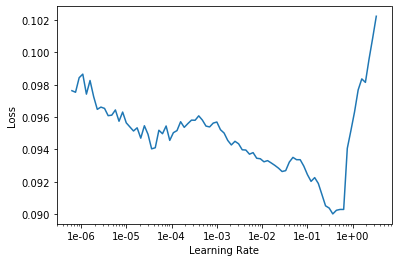

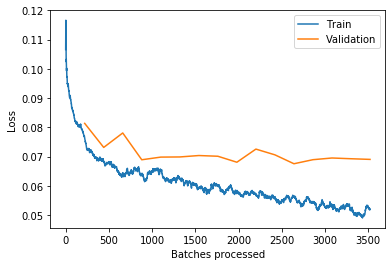

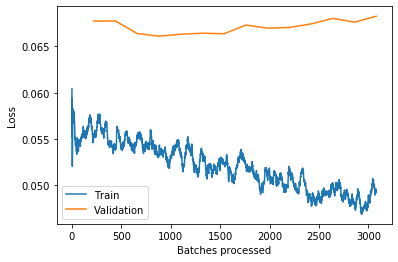

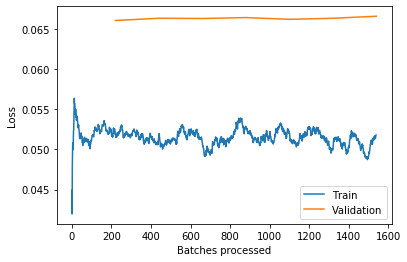

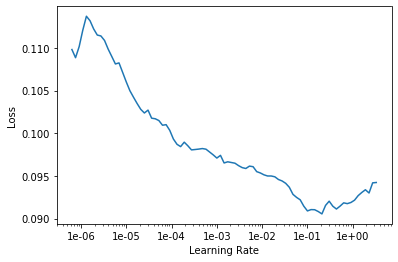

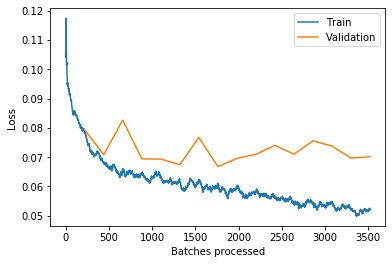

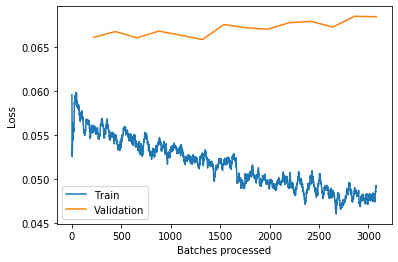

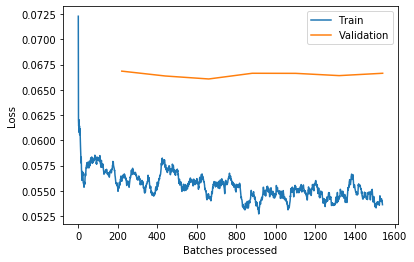

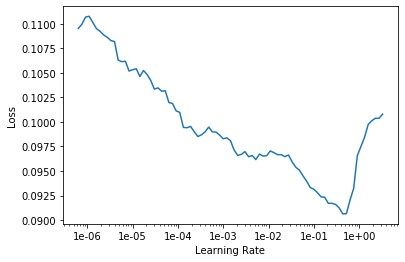

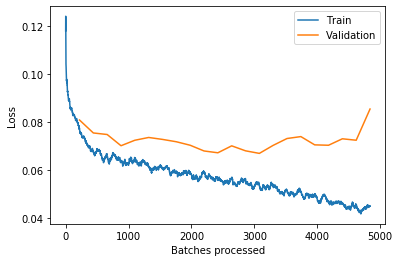

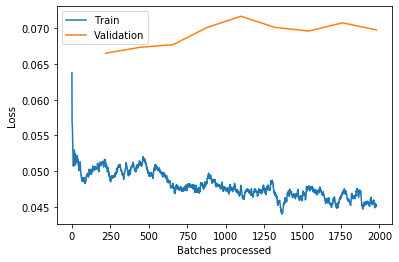

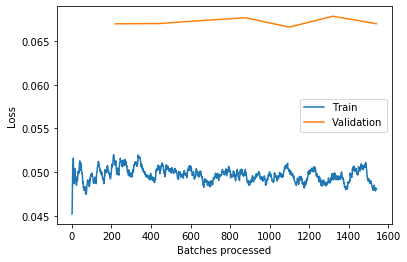

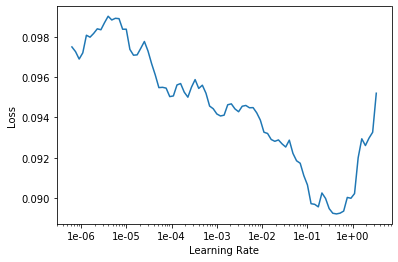

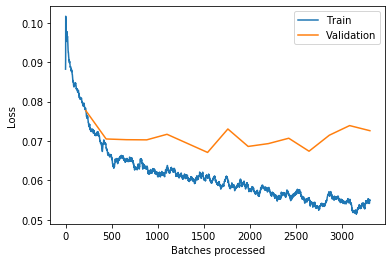

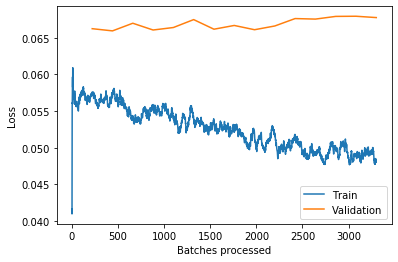

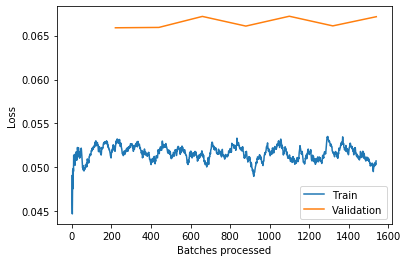

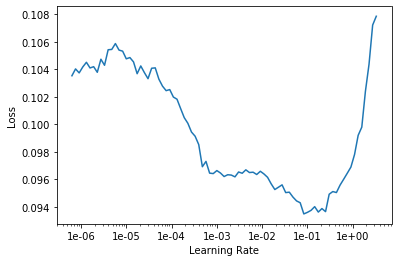

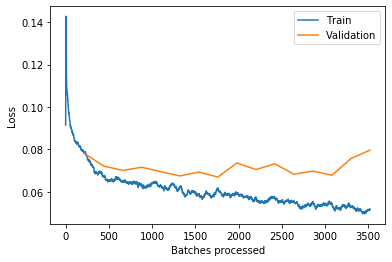

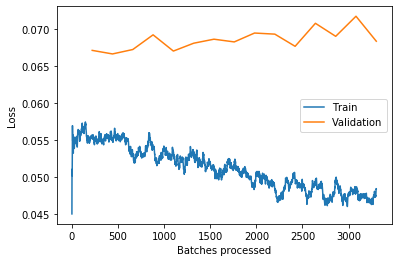

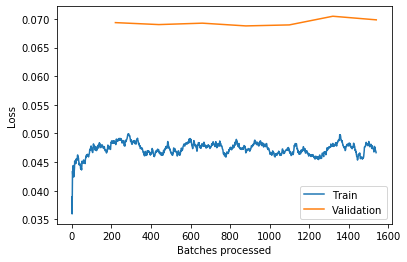

In [34]:
labels_ensemble = [train_and_eval_tabular_learner(comp_train_df, comp_test_df, valid_idx) for i in range(0, 5)]

In [35]:
pred_labels = torch.cat(labels_ensemble).reshape(-1, 1000)

In [36]:
torch.round(tensor(0.2)), torch.round(tensor(0.9)), torch.round(tensor(0.5))

(tensor(0.), tensor(1.), tensor(0.))

In [37]:
ensemble_labels = pred_labels.float().mean(dim=0).round()

### Data Checks

In [38]:
valid_ds = comp_train_df[comp_train_df.index.isin(valid_idx)].groupby('installation_id').last()['accuracy']
valid_ds.apply(lambda x : feature_engineering.convert_to_accuracy_group(x)).value_counts(normalize=True)

3    0.450747
0    0.283066
1    0.137244
2    0.128943
Name: accuracy, dtype: float64

In [39]:
pd.Series(ensemble_labels).value_counts(normalize=True)

3.0    0.453
2.0    0.233
0.0    0.183
1.0    0.131
dtype: float64

## Submission

In [40]:
submission_df = pd.DataFrame({'installation_id': comp_test_df['installation_id'], 'accuracy_group': ensemble_labels.int()})
submission_df

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3
...,...,...
995,fee254cf,3
996,ff57e602,0
997,ffc73fb2,3
998,ffe00ca8,1


In [41]:
def prepare_submission(submission_df):
    sample_submission_df = pd.read_csv(path/'sample_submission.csv')
    sample_submission_df.drop('accuracy_group', inplace = True, axis = 1)
    sample_submission_df = sample_submission_df.merge(submission_df, on = 'installation_id')
    sample_submission_df = sample_submission_df[['installation_id', 'accuracy_group']]
    sample_submission_df.to_csv('submission.csv', index = False)

In [42]:
prepare_submission(submission_df)

In [43]:
!head submission.csv

installation_id,accuracy_group
00abaee7,3
01242218,3
017c5718,3
01a44906,3
01bc6cb6,3
02256298,3
0267757a,3
027e7ce5,1
02a29f99,0


In [44]:
!cat submission.csv | wc -l

1001
